# Logistic regression with $\ell_1$ regularization

In this example, we use CVXPY to train a logistic regression classifier with $\ell_1$ regularization. We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{0, 1\}$ are associated boolean classes; we assume the first component of each $x_i$ is $1$.

Our goal is to construct a linear classifier $\hat y = \mathbb{1}[\beta^T x > 0]$, which is $1$ when $\beta^T x$ is positive and $0$ otherwise.  We model the posterior probabilities of the classes given the data linearly, with

$$
\log \frac{\mathrm{Pr} (Y=1 \mid X = x)}{\mathrm{Pr} (Y=0 \mid X = x)} = \beta^T x.
$$

This implies that

$$
\mathrm{Pr} (Y=1 \mid X = x) = \frac{\exp(\beta^T x)}{1 + \exp(\beta^T x)}, \quad
\mathrm{Pr} (Y=0 \mid X = x) = \frac{1}{1 + \exp(\beta^T x)}.
$$

We fit $\beta$ by maximizing the log-likelihood of the data, plus a regularization term $\lambda \|{\beta_{1:}}\|_1$ with $\lambda > 0$:

$$
\ell(\beta) = \sum_{i=1}^{m} y_i \beta^T x_i - \log(1 + \exp (\beta^T x_i)) - \lambda \|{\beta_{1:}}\|_1.
$$

Because $\ell$ is a concave function of $\beta$, this is a convex optimization problem.



In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In the following code we generate data with $n=20$ features by randomly choosing $x_i$ and a sparse $\beta_{\mathrm{true}} \in {\bf R}^n$.
We then set $y_i = \mathbb{1}[\beta_{\mathrm{true}}^T x_i  - z_i > 0]$, where the $z_i$ are i.i.d. normal random variables.
We divide the data into training and test sets with $m=1000$ examples each.

In [2]:
np.random.seed(1)
n = 20
m = 1000
density = 0.2
beta_true = np.random.randn(n)
idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0

sigma = 3
X = np.random.normal(0, 5, size=(m,n))
X[:, 0] = 1.0
Y = X @ beta_true + np.random.normal(0, sigma, size=m)
Y[Y > 0] = 1
Y[Y <= 0] = 0

X_test = np.random.normal(0, 5, size=(m, n))
X_test[:, 0] = 1.0
Y_test = X_test @ beta_true + np.random.normal(0, sigma, size=(m,1))
Y_test[Y_test > 0] = 1
Y_test[Y_test <= 0] = 0

We next formulate the optimization problem using CVXPY.

In [3]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
log_likelihood = cp.sum(
    cp.multiply(Y, X @ beta) -
    cp.log_sum_exp(cp.vstack([np.zeros(m), X @ beta]), axis=0) - 
    lambd * cp.norm(beta[1:], 1)
)
problem = cp.Problem(cp.Maximize(log_likelihood))

We solve the optimization problem for a range of $\lambda$ to compute a trade-off curve.
We then plot the train and test error over the trade-off curve.
A reasonable choice of $\lambda$ is the value that minimizes the test error.

In [4]:
def error(scores, labels):
  scores[scores > 0] = 1
  scores[scores <= 0] = 0
  return np.sum(np.abs(scores - labels)) / float(np.size(labels))

In [5]:
trials = 100
train_error = np.zeros(trials)
test_error = np.zeros(trials)
lambda_vals = np.logspace(-2, 0, trials)
beta_vals = []
for i in range(trials):
    lambd.value = lambda_vals[i]
    problem.solve()
    train_error[i] = error(X @ beta.value, Y)
    test_error[i] = error(X_test @ beta.value, Y_test)
    beta_vals.append(beta.value)

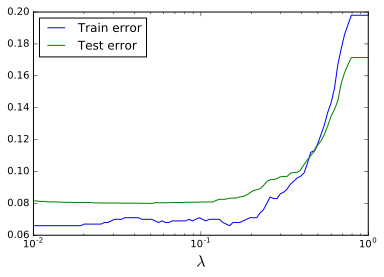

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

We also plot the regularization path, or the $\beta_i$ versus $\lambda$. Notice that 
a few features remain non-zero longer for larger $\lambda$ than the rest, which suggests that these features are the most important. 

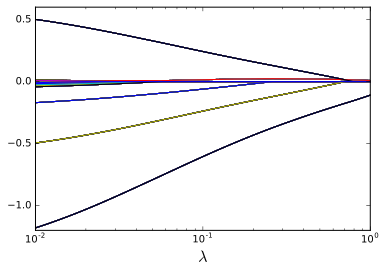

In [7]:
for i in range(n):
    plt.plot(lambda_vals, [wi for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")